Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><a style="font-size: 3em; text-align: center; vertical-align: middle;" href="https://moodle.polytechnique.fr/course/view.php?id=19260">[CSC2S004EP - 2024] - Introduction to Machine Learning</a>
</td>
  </tr>
</table>

<a style="font-size: 3em;">Lab Session 8: Decision Trees</a>

J.B. Scoggins - Adrien Ehrhardt - Jesse Read

# Introduction

In this lab you will learn how to use decision trees and ensemble methods to build a model which predicts the average price of houses for neighborhoods in the US state of California. We will make heavy use of the following libraries, to which you are already familiar, to play with the dataset and build our models:

- [Pandas](https://pandas.pydata.org/) - python data analysis library
- [Scikit-learn](https://scikit-learn.org/stable/) - python machine learning library

Recall from the lecture that decision trees can be a powerful way to generate "cheap" (because fast to build) and efficient models for classification and regression. Some of the advantages of decision trees over other models include:

- They are easy to use, requiring little data preprocessing,
- Can be easily interpreted,
- Are useful for feature selection,
- Fast to build and evaluate,
- Non-linear.

On the other hand, some of the disadvantages include:

- Greedy tree building algorithms are not necessarily optimal (this is NP-complete),
- The number of samples is logarithmic in tree depth,
- Trees are unstable, meaning they can be easily perturbed (you would get a totally different tree) with small differences in data (e.g. subsamples),
- Decision trees tend to overfit the data,
- Since they only consider a single feature at a time, they have difficulty handling [model additivity](https://en.wikipedia.org/wiki/Additive_model) (*i.e.* when each feature has an independent - w.r.t. other features - impact on the feature to predict). On the other hand, they are good with [multiplicative models](https://en.wikipedia.org/wiki/Multiplicative_function) where the impact of a feature depends on some other feature(s).

Often, decision trees can be poor classifiers or regressors. However, because of their fast training speed, they can be used to generate ensemble models, such as random forests, with boosting and bagging.
Often, the algorithm that is boosted or bagged is called the **weak learner**, meaning that they would be pretty lame on their own, but ensembling many weak learners can lead to a **strong learner**.
We will play with some of these concepts during this lab in order to compare the resulting model to basic decision tree performance. Before we get started, let's import and load the different packages we will use.

In [1]:
# Import required packages
from IPython.display import display
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import fetch_california_housing

# Setup pandas options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

As we will be using the Pandas library, it is important you remember the core functionality from your previous labs.
If you want a quick Pandas refresher, you can follow a simple Pandas tutorial provided by the [Google Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

This lab will partially resemble lab_session_01, insofar as we will explore a dataset, and adjust decision trees.

# Step 1: Get to know your dataset

We will make use of the [California housing price dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) (this will be useful later on). This data was compiled from the 1990 census taken in California.  You can download the dataset with the Pandas code below.

In [2]:
# Get the housing data
housing_data = fetch_california_housing(as_frame=True)
housing_data = housing_data.frame

As you are probably well aware at this point, one of the most important aspects of machine learning and data science is to first understand your dataset. Whenever you are introduced to a new dataset, it is crucial to study the data to help your model building strategy. The Pandas library is very useful for this purpose.

Using the describe() method to print information about the `housing_data` data frame, answer the following questions:

In [3]:
# YOUR CODE HERE
display(housing_data.describe())


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0
mean,3.9,28.6,5.4,1.1,1425.5,3.1,35.6,-119.6,2.1
std,1.9,12.6,2.5,0.5,1132.5,10.4,2.1,2.0,1.2
min,0.5,1.0,0.8,0.3,3.0,0.7,32.5,-124.3,0.1
25%,2.6,18.0,4.4,1.0,787.0,2.4,33.9,-121.8,1.2
50%,3.5,29.0,5.2,1.0,1166.0,2.8,34.3,-118.5,1.8
75%,4.7,37.0,6.1,1.1,1725.0,3.3,37.7,-118.0,2.6
max,15.0,52.0,141.9,34.1,35682.0,1243.3,42.0,-114.3,5.0


In [4]:
# number_of_features = ...  # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE
number_of_features = 9


2. How many samples are there?

In [5]:
# number_of_samples = ...  # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE
number_of_samples = 20640

3. Plot the houses on a map and color them w.r.t. their median price

*Hint 1*: you can simply plot the houses as points defined by their 'Longitude' (horizontal axis) vs 'Latitude' (vertical axis) features. See [`df.plot.scatter(...)`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html).

*Hint 2*: the `c` parameter controls how points are colored.

Compare with a map of california such as [this one](https://www.google.com/search?q=california+maps&client=firefox-b-d&tbm=isch&source=iu&ictx=1&fir=KnETshNcnsi1VM%253A%252CMK2MjhZw7xRERM%252C_&vet=1&usg=AI4_-kSz1S_ut8rli9wcyp0A12LG1aVofg&sa=X&ved=2ahUKEwju59vrxsDhAhXqyIUKHZAkBBgQ9QEwBXoECAgQDg#imgrc=KnETshNcnsi1VM:) (no answer is expected).

Text(0.5, 1.0, 'California Map by Mediac Prices')

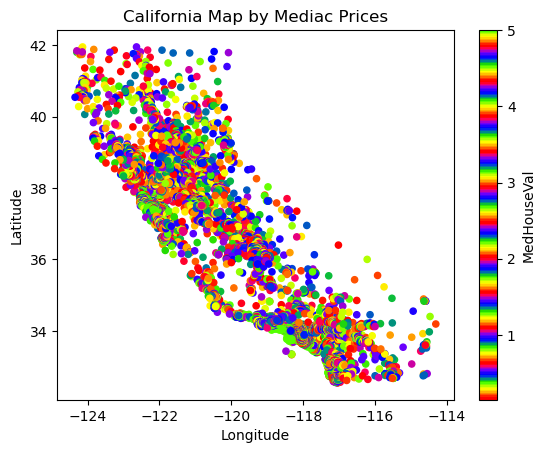

In [6]:
# YOUR CODE HERE
housing_data.plot.scatter(x = "Longitude", y = "Latitude", c = "MedHouseVal", colormap = 'prism')
plt.xlabel ("Longitude")
plt.ylabel ("Latitude")

plt.title("California Map by Mediac Prices")

4. Which feature are we likely to want to predict (using all the others)? Put its name (as a `str`) in `feature_to_predict`.

Text(0.5, 1.0, 'California Map by Mediac Prices')

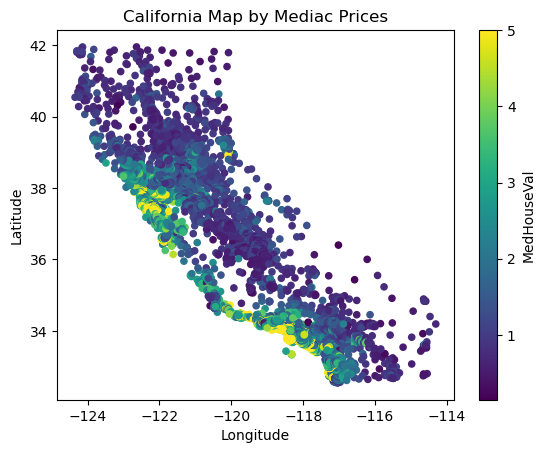

In [7]:
feature_to_predict = "MedHouseVal"
# YOUR CODE HERE
housing_data.plot.scatter(x = "Longitude", y = "Latitude", c = "MedHouseVal", colormap = 'viridis')

plt.xlabel ("Longitude")
plt.ylabel ("Latitude")

plt.title("California Map by Mediac Prices")

In the following we inspect the feature distributions. 

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0
mean,3.9,28.6,5.4,1.1,1425.5,3.1,35.6,-119.6,2.1
std,1.9,12.6,2.5,0.5,1132.5,10.4,2.1,2.0,1.2
min,0.5,1.0,0.8,0.3,3.0,0.7,32.5,-124.3,0.1
25%,2.6,18.0,4.4,1.0,787.0,2.4,33.9,-121.8,1.2
50%,3.5,29.0,5.2,1.0,1166.0,2.8,34.3,-118.5,1.8
75%,4.7,37.0,6.1,1.1,1725.0,3.3,37.7,-118.0,2.6
max,15.0,52.0,141.9,34.1,35682.0,1243.3,42.0,-114.3,5.0


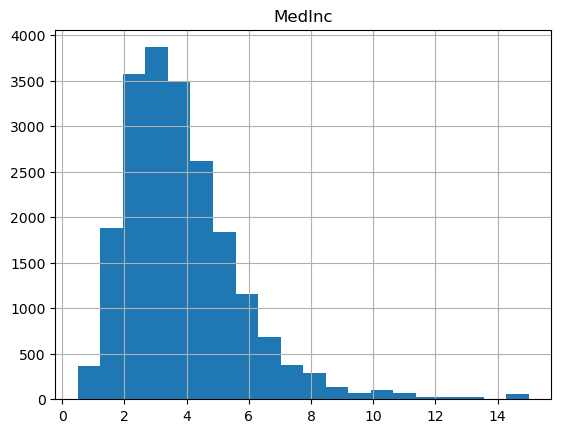

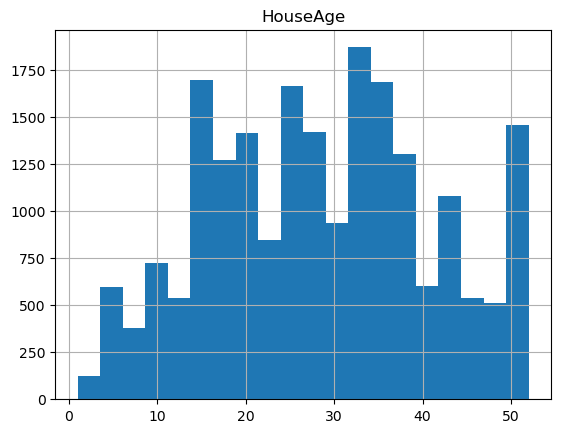

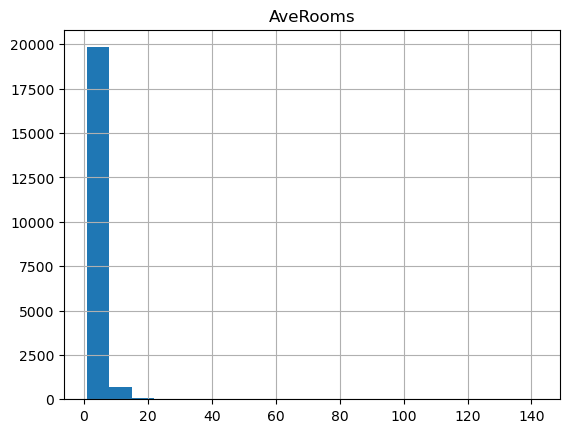

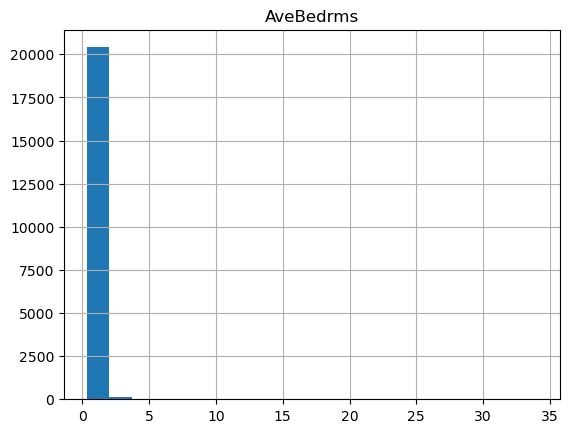

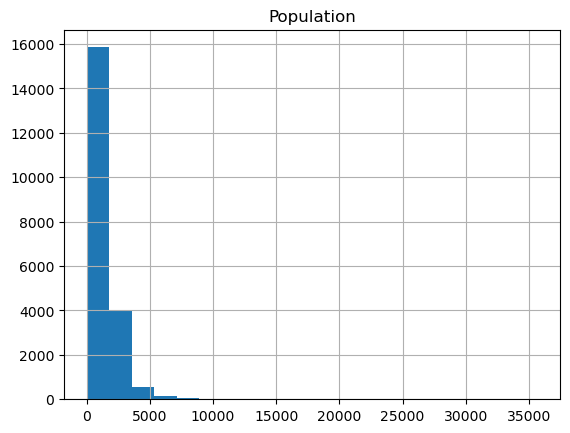

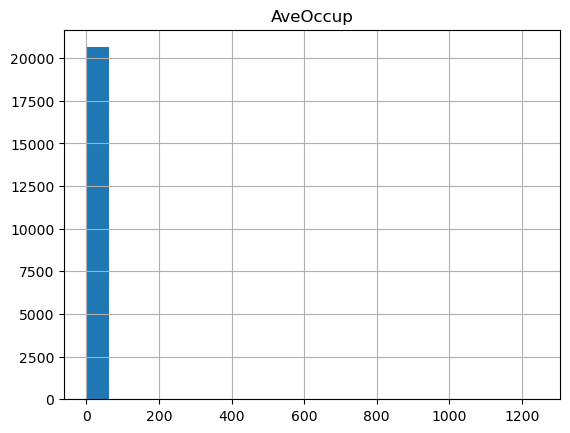

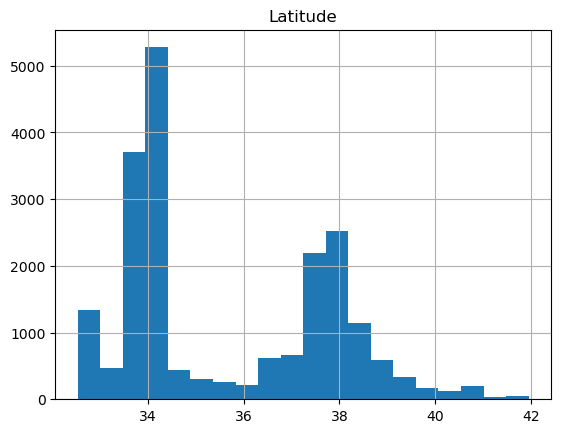

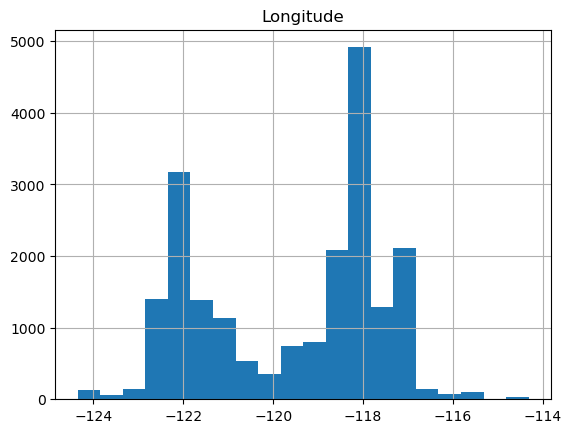

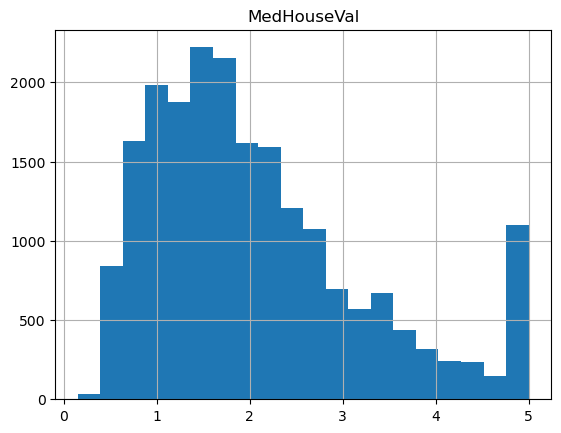

In [8]:
display(housing_data.describe())
for var in housing_data.columns.to_list():
    housing_data.hist(column=var, bins=20)
    plt.show()

Before building a model, let's build some expectation for what the important features are. Then we can compare to decision trees later on. Use any method you like that you have seen in the course so far (e.g., inspecting coefficients, measuring correlation) to determine which features are the most important ones (for predicting the target/class label). (We are interested in an approximate ranking from 1 to #features; not being 'too far off' will get you full marks). 

In [9]:
importance = {
    x: 0 for x in housing_data.columns.values.tolist()
} # <-- redefine the values however you like

# YOUR CODE HERE
l =[]
for x in housing_data.columns:
    if x != 'MedHouseVal':
        correlation = np.corrcoef(housing_data[x], housing_data['MedHouseVal'])[0, 1]
        l.append((x, correlation))
        
l.sort(key = lambda x: x[1], reverse = True)

for i in range(len(l)):
    importance[l[i][0]] = i+2

importance["MedHouseVal"] = 1
print(importance)

{'MedInc': 2, 'HouseAge': 4, 'AveRooms': 3, 'AveBedrms': 8, 'Population': 6, 'AveOccup': 5, 'Latitude': 9, 'Longitude': 7, 'MedHouseVal': 1}


In the following we use scatter plots to visualize each pair of correlated variables.

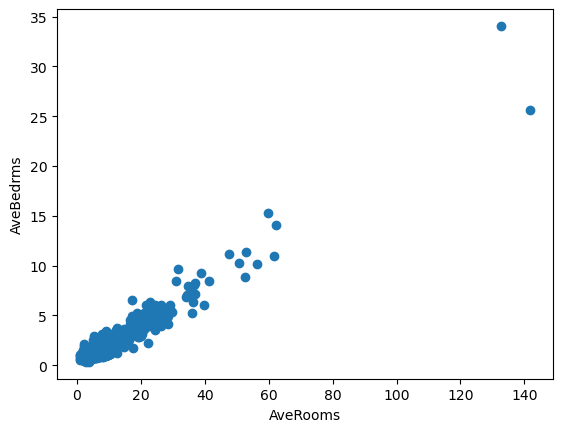

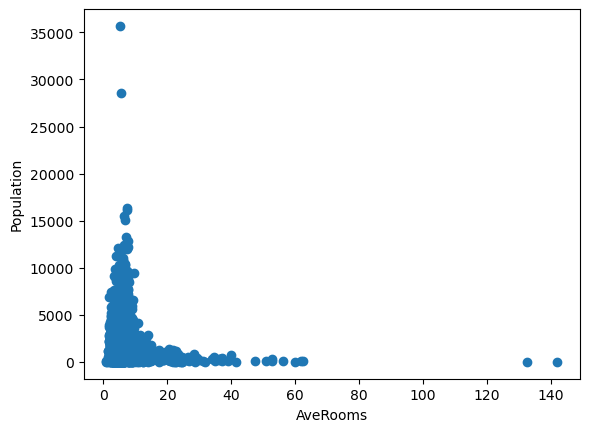

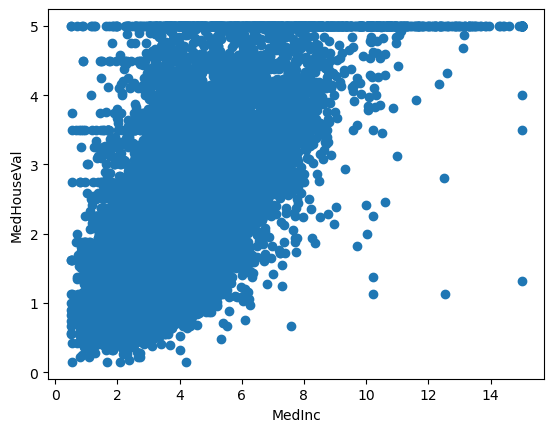

In [10]:
for var1, var2 in zip(['AveRooms', 'AveRooms', 'MedInc'],
                      ['AveBedrms', 'Population', 'MedHouseVal']):
    plt.scatter(housing_data[var1], housing_data[var2])
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()

Notice anything strange about the scatter plot with `MedHouseVal`? What's going here? Investigate in order to answer the following question.

In [11]:
answers = ['Prices in Los Angeles are skewing the data',
           'The data has been corrupted by missing values',
           'Prices have been capped at $500,000 in the data']
# index_of_correct_answer = ...  # TODO UNCOMMENT THIS LINE
# YOUR CODE HERE
index_of_correct_answer = 2

# Step 2: Train a simple decision tree to predict median house values

At this point we have a pretty good idea about our dataset. Let's try and create a simple model based on a decision tree.

Implement the function `custom_train_test_split` to split the dataset into a training and validation set. You may use the [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from Scikit-learn with the `shuffle` option. Check that the reduced datasets make sense with the `describe()` function.

In [12]:
def custom_train_test_split(hs_data: pd.DataFrame = housing_data,
                            feature_to_predict: str = feature_to_predict,
                            test_size: float = 0.3,
                            shuffle: bool = False):
    """
    Wrapper around sklearn's train_test_split

    :param pd.DataFrame hs_data: our dataset (default: housing_data)
    :param str feature_to_predict: the feature to predict (default: feature_to_predict defined earlier)
    :param float test_size: proportion of samples in the test data (default: 0.3)
    :param bool shuffle: passed to sklearn => whether or not to shuffle the data or take the test_size first ones
    """
    # YOUR CODE HERE
    X = hs_data.drop(columns=[feature_to_predict])
    y = hs_data[feature_to_predict]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=42)
    return X_train, X_test, y_train, y_test

In [13]:
training_features, testing_features, training_target, testing_target = custom_train_test_split(shuffle=False)
training_features.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,14448.0,14448.0,14448.0,14448.0,14448.0,14448.0,14448.0,14448.0
mean,3.8,29.3,5.4,1.1,1437.0,3.0,35.3,-119.1
std,1.9,12.4,2.8,0.5,1141.3,5.5,2.0,1.8
min,0.5,1.0,0.8,0.4,3.0,0.7,32.7,-124.3
25%,2.5,19.0,4.4,1.0,787.0,2.4,33.9,-120.8
50%,3.4,30.0,5.2,1.1,1163.0,2.8,34.1,-118.3
75%,4.6,38.0,6.0,1.1,1735.0,3.3,37.4,-118.0
max,15.0,52.0,141.9,34.1,28566.0,599.7,42.0,-114.3


In [14]:
assert training_features.shape[0] == training_target.shape[0]
assert testing_features.shape[0] == testing_target.shape[0]


A major assumption in standard machine learning settings, is that the training and test data are from identical distributions. You should check that it's the case, and then correct it if not by making a new call to the `custom_train_test_split` function with different parameter(s) and storing its results by overwriting `training_features`, `testing_features`, `training_target`, `testing_target`.

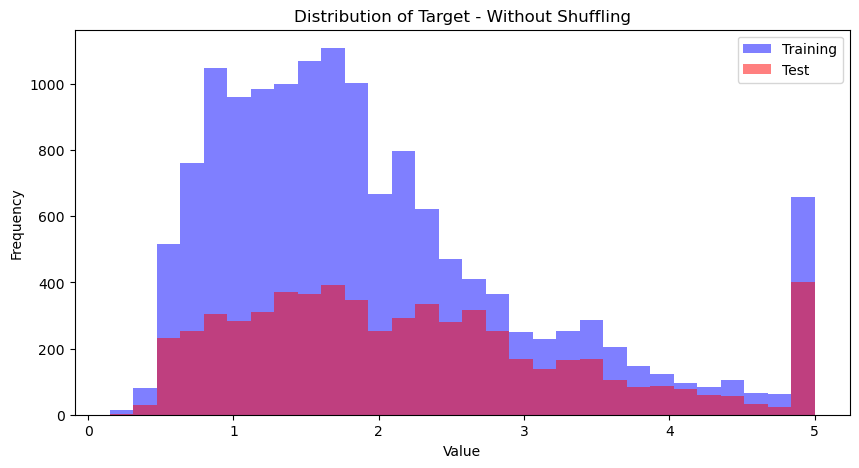

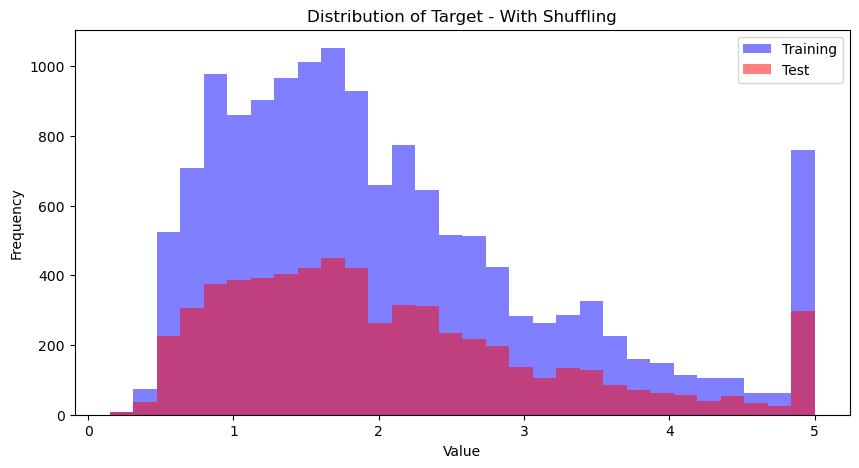

In [15]:
training_features_ns, testing_features_ns, training_target_ns, testing_target_ns = custom_train_test_split(
    hs_data=housing_data,
    feature_to_predict=feature_to_predict,
    shuffle=False
)

# Split with shuffling
training_features_s, testing_features_s, training_target_s, testing_target_s = custom_train_test_split(
    hs_data=housing_data,
    feature_to_predict=feature_to_predict,
    shuffle=True
)

def plot_distributions(train, test, title):
    plt.figure(figsize=(10, 5))
    plt.hist(train, bins=30, alpha=0.5, label='Training', color = "b" )
    plt.hist(test, bins=30, alpha=0.5, label='Test', color = "r" )
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Your plot on unshuffled data here
plot_distributions(training_target_ns, testing_target_ns, "Distribution of Target - Without Shuffling")
## Notice anything strange?

# Your plot on shuffled data here
plot_distributions(training_target_s, testing_target_s, "Distribution of Target - With Shuffling")
# YOUR CODE HERE

Use the `DecisionTreeRegressor` from Scikit-learn to create a new decision tree model with a max depth of 3, and the squared error criterion as a measure of 'impurity', and train it on the training dataset using the `fit()` method.

*Hint*: You can find the API for DecisionTreeRegressor [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

In [16]:
# model = ...
# YOUR CODE HERE
model = DecisionTreeRegressor(max_depth = 3, criterion = 'squared_error')
model.fit(training_features, training_target)

DecisionTreeRegressor(max_depth=3)

Let's get a sense of how well the tree fits the data.

Use the tree's `predict` method on the testing features to get a prediction for the testing dataset.

In [17]:
# prediction = ...  # <- TO UNCOMMENT AND COMPLETE

# YOUR CODE HERE
prediction = model.predict(testing_features)
prediction

array([2.84324296, 3.57527282, 3.57527282, ..., 1.01592971, 1.01592971,
       1.01592971])

Compute the mean squared error using the `mean_squared_error()` function from Scikit-learn and assign it to variable `MSE`.

In [18]:
# MSE = ...  # <- TO UNCOMMENT AND COMPLETE

# YOUR CODE HERE
MSE = mean_squared_error(prediction, testing_target)

MSE

0.8140733038785962

Plot a scatter plot of the predicted median house values versus the testing target values. 

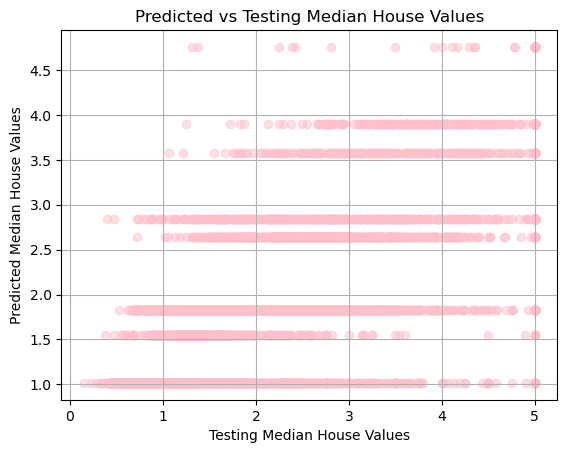

In [19]:
# plt...  # <- TO UNCOMMENT AND COMPLETE

# YOUR CODE HERE
plt.scatter(testing_target, prediction, alpha=0.5, color = "pink")  
plt.title('Predicted vs Testing Median House Values')  
plt.xlabel('Testing Median House Values') 
plt.ylabel('Predicted Median House Values')  
plt.grid(True)  
plt.show()

Check that you understand the results.

We can visualize the trained decision tree with the following code. As stated in the beginning, one advantage of such trees is that they are easily interpretible with graphs like this one. If you did not manage to install `graphviz`, the following cell will produce an error. You may leave it as is and use the subsequent cell.

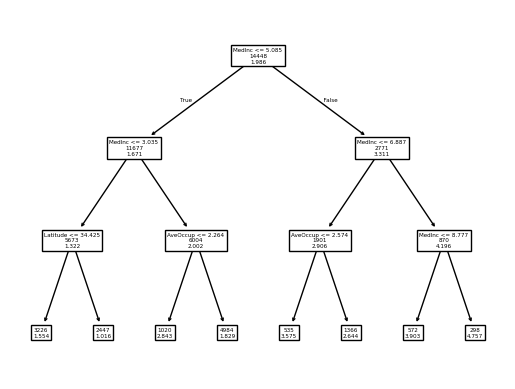

In [20]:
plot_tree(model, feature_names=training_features.columns.tolist(), impurity=False, label='none');

What is the most important feature, according to the tree? Put its name as a string in `most_important_feature`.

In [21]:
features = housing_data.columns.values.tolist()
most_important_feature = "MedInc"  # TODO SELECT IT HERE

# YOUR CODE HERE


With the same data as previously, train and test, for different maximum tree-depth. Identify the one that performs best. 

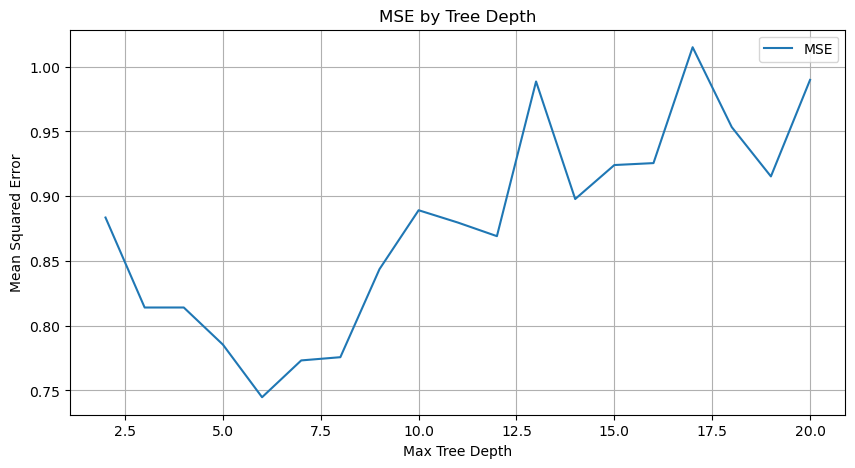

In [22]:
best_max_depth = 6 # <-- TODO: Change this value to the best one.

# YOUR CODE HERE
mse = []
for depth in range(2, 21):
    model = DecisionTreeRegressor(max_depth=depth, criterion = 'squared_error')
    model.fit(training_features, training_target)
    prediction = model.predict(testing_features)
    mse.append(mean_squared_error(prediction, testing_target))

plt.figure(figsize=(10, 5))
plt.plot(range(2, 21), mse, label='MSE')
plt.xlabel('Max Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('MSE by Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

# Step 3: A little investigation

We have seen that a single decision tree is not the best estimator we could have hoped for. Yet, sometimes they are very well suited. 

Create a dataset suited to a *classification* model, in numpy arrays `X` and `y`; having 1000 instances (*i.e.* rows) and 2 features (*i.e.* columns, wrt `X`). The goal: design the dataset in any way, such as to highlight some strength(s) of a decision tree (`DecisionTreeClassifier`); such that it should outperform a neural network (say, `sklearn.neural_network.MLPClassifier` with default parameters) on this data that you have created, under classification accuracy.  

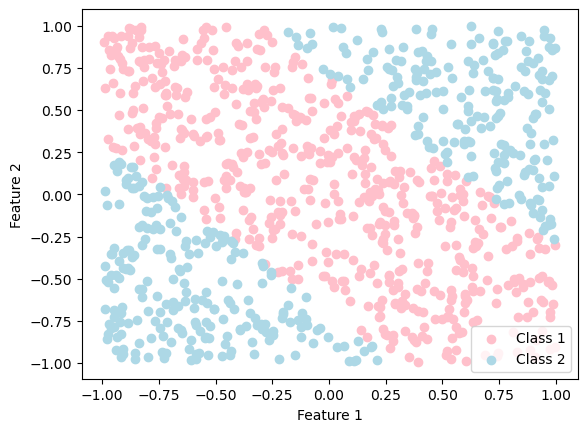

In [23]:
# X = ...  # TODO UNCOMMENT
# y = ...  # TODO UNCOMMENT
np.random.seed(42)
# YOUR CODE HERE
X = np.random.rand(1000, 2) * 2 - 1 
y = (np.abs(X[:, 0] + X[:, 1] )> 0.7)

plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color="pink", label='Class 1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color="lightblue", label='Class 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [24]:
assert X.shape[0] == 1000
assert y.shape[0] == X.shape[0]
assert X.shape[1] == 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle=True)

# Step 4: Ensemble methods

We can improve our predictions using a number of ensemble techniques such as bagging, random forests, and boosting.  Using Scikit-learn, it is easy to try all of these models. Today we will have a look at: [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor).

In [25]:
def fit_and_get_test_error(model,
                           training_features: np.array = training_features,
                           training_target: np.array = training_target,
                           testing_features: np.array = testing_features,
                           task: str = "regression"):
    model.fit(training_features, training_target)
    prediction = model.predict(testing_features)
    if task == "regression":
        return mean_squared_error(prediction, testing_target)
    else:
        return accuracy_score(testing_target, prediction)

Create and fit a bagging regressor based on decision trees (each with a max depth of 10) using 100 such trees, and maximum samples and features of 50%. Compute the MSE on the testing dataset and compare the true median house values with the predictions using a scatter plot.

0.7927037222217695


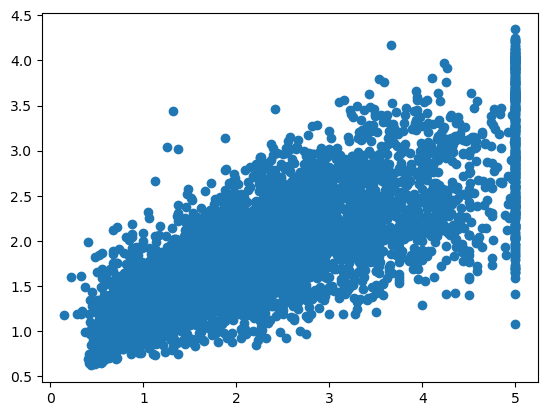

In [26]:
# model = ...  # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE

model = BaggingRegressor(DecisionTreeRegressor(max_depth=10),
                         n_estimators=100,
                         max_samples=0.5,
                         max_features=0.5)
bagging_prediction = fit_and_get_test_error(model)
print(bagging_prediction)
plt.scatter(testing_target, model.predict(testing_features));

Plot the MSE for a number of combinations of `max_depth` and `n_estimators` (as suggested in the code); other hyper parameters as default. Make use of the `fit_and_get_test_error` function.

Compared to a single decision tree of depth 3 (the baseline below), what **factor** of improvement can we get? For example, if a decision tree has MSE of 1.0 (*hint*: you should thus normalize the MSE of the baseline), what would we expect from a good ensemble (up to and including 20 models) with an appropriate depth. Store the result in `ans`.

In [27]:
# Baseline
mse_b = fit_and_get_test_error(DecisionTreeRegressor(max_depth=3))

# Use these hyperparameters:
max_depths = [1, 2, 4, 8, 15, 20]
num_estimators = [1, 2, 3, 4, 5, 10, 20]

# Store the results here:
mse = np.zeros((len(num_estimators), len(max_depths)))

# Store (overwrite with) the answer to the question in this variable:
ans = 0  # this should probably resemble ans = lowest mse / mse_b

# YOUR CODE HERE
for i, n_est in enumerate(num_estimators):
    for j, depth in enumerate(max_depths):
        model = BaggingRegressor(
            DecisionTreeRegressor(max_depth=depth),
            n_estimators=n_est,
            random_state=42
        )
        mse[i, j] = fit_and_get_test_error(model, training_features, training_target, testing_features)

normalized_mse = mse/mse_b
best_improvement_factor = np.min(normalized_mse)
ans = best_improvement_factor  
print(f"The answer is: {ans}")

The answer is: 0.698116921928953


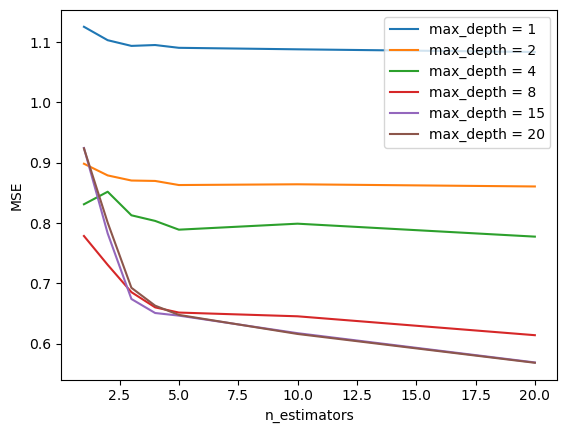

In [67]:
# Plot MSE curves for each model on a single plot
for k, md in enumerate(max_depths):
    plt.plot(num_estimators,mse[:, k], label='max_depth = %d' % md)
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend()
plt.show()

We will have a closer look at ensembles later in the course.